------------------------
##Name: Anuva Negi             
###UTA ID: 1002238067         
------------------------


#PART 1

In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
from typing import NamedTuple
import pandas as pd

sns.set_theme()

# ------------------------
# Parameters
# ------------------------
class Params(NamedTuple):
    total_episodes: int
    seed: int
    is_slippery: bool
    n_runs: int
    proba_frozen: float
    savefig_folder: Path

params = Params(
    total_episodes=2000,
    seed=42,
    is_slippery=False,
    n_runs=1,
    proba_frozen=0.9,
    savefig_folder=Path("./figures/"),
)

param_grid = {
    "learning_rate": [0.1, 0.5, 0.9],
    "gamma": [0.5, 0.9, 0.99],
    "epsilon": [0.05, 0.1, 0.3],
}

rng = np.random.default_rng(params.seed)
params.savefig_folder.mkdir(parents=True, exist_ok=True)

# ------------------------
# Q-Learning
# ------------------------
class QLearning:
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()

    def update(self, state, action, reward, new_state):
        delta = reward + self.gamma * np.max(self.qtable[new_state]) - self.qtable[state, action]
        self.qtable[state, action] += self.learning_rate * delta

    def reset_qtable(self):
        self.qtable = np.zeros((self.state_size, self.action_size))

class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def choose_action(self, action_space, state, qtable):
        if rng.uniform(0, 1) < self.epsilon:
            return action_space.sample()
        else:
            max_ids = np.where(qtable[state, :] == np.max(qtable[state, :]))[0]
            return rng.choice(max_ids)

# ------------------------
# Policy Iteration
# ------------------------
def policy_iteration(env, gamma=0.99, theta=1e-6):
    policy = np.zeros(env.observation_space.n, dtype=int)
    V = np.zeros(env.observation_space.n)

    def one_step_lookahead(s, V):
        A = np.zeros(env.action_space.n)
        for a in range(env.action_space.n):
            for prob, next_state, reward, done in env.unwrapped.P[s][a]:
                A[a] += prob * (reward + gamma * V[next_state])
        return A

    while True:
        while True:
            delta = 0
            for s in range(env.observation_space.n):
                v = V[s]
                a = policy[s]
                V[s] = sum(prob * (reward + gamma * V[next_state])
                           for prob, next_state, reward, done in env.unwrapped.P[s][a])
                delta = max(delta, abs(v - V[s]))
            if delta < theta:
                break

        policy_stable = True
        for s in range(env.observation_space.n):
            old_action = policy[s]
            action_values = one_step_lookahead(s, V)
            best_action = np.argmax(action_values)
            policy[s] = best_action
            if old_action != best_action:
                policy_stable = False

        if policy_stable:
            break

    return policy, V

def evaluate_policy(env, policy, episodes=100):
    total_rewards = 0
    for _ in range(episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = policy[state]
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_rewards += reward
    return total_rewards / episodes


Top 3 hyperparameter sets for 4x4:
Map Size  Alpha  Gamma  Epsilon  Avg Reward (Last 100)
     4x4    0.1    0.9     0.05                   1.00
     4x4    0.5    0.5     0.05                   1.00
     4x4    0.9    0.5     0.05                   0.99

Top 3 hyperparameter sets for 7x7:
Map Size  Alpha  Gamma  Epsilon  Avg Reward (Last 100)
     7x7    0.5   0.90     0.05                   1.00
     7x7    0.9   0.99     0.05                   0.99
     7x7    0.1   0.99     0.10                   0.99

Top 3 hyperparameter sets for 9x9:
Map Size  Alpha  Gamma  Epsilon  Avg Reward (Last 100)
     9x9    0.1    0.5     0.05                    1.0
     9x9    0.1    0.5     0.10                    1.0
     9x9    0.1    0.9     0.10                    1.0


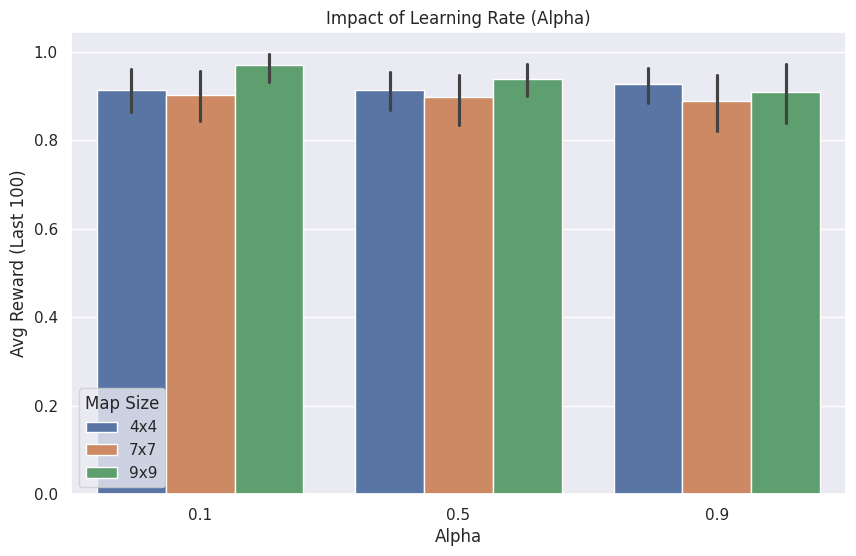

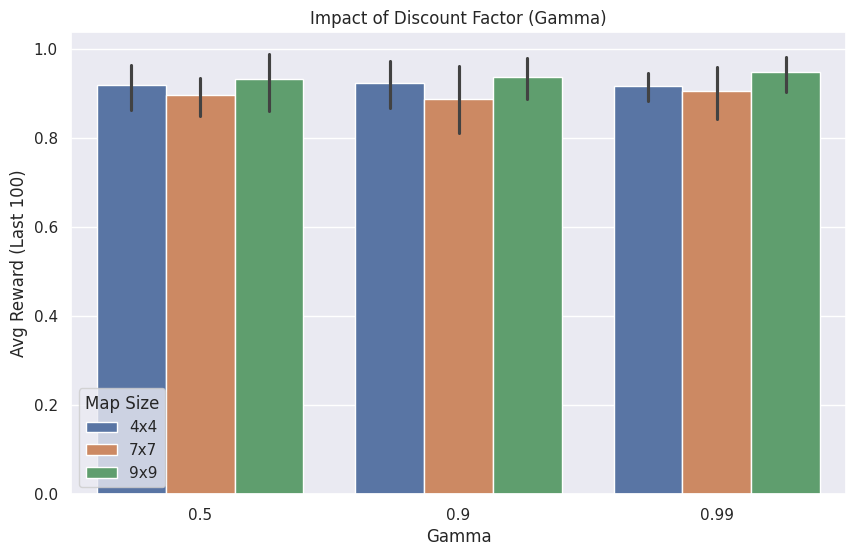

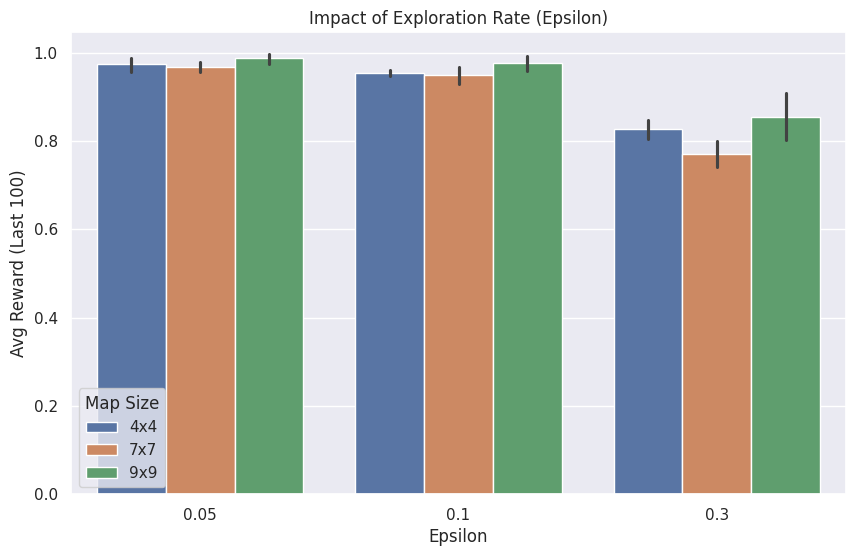

In [ ]:
# ------------------------
# Hyperparameter Experiments - to get best hyperparameters
# ------------------------
map_sizes = [4, 7, 9]
experiment_results = []

for map_size in map_sizes:
    for alpha in param_grid["learning_rate"]:
        for gamma in param_grid["gamma"]:
            for epsilon in param_grid["epsilon"]:
                env = gym.make(
                    "FrozenLake-v1",
                    is_slippery=params.is_slippery,
                    render_mode="rgb_array",
                    desc=generate_random_map(size=map_size, p=params.proba_frozen, seed=params.seed),
                )

                state_size = env.observation_space.n
                action_size = env.action_space.n

                agent = QLearning(alpha, gamma, state_size, action_size)
                policy = EpsilonGreedy(epsilon)

                rewards = []
                for episode in range(params.total_episodes):
                    state, _ = env.reset(seed=params.seed)
                    done = False
                    total_reward = 0

                    while not done:
                        action = policy.choose_action(env.action_space, state, agent.qtable)
                        new_state, reward, terminated, truncated, _ = env.step(action)
                        agent.update(state, action, reward, new_state)
                        state = new_state
                        total_reward += reward
                        done = terminated or truncated

                    rewards.append(total_reward)

                avg_reward_last_100 = np.mean(rewards[-100:])

                experiment_results.append({
                    "Map Size": f"{map_size}x{map_size}",
                    "Alpha": alpha,
                    "Gamma": gamma,
                    "Epsilon": epsilon,
                    "Avg Reward (Last 100)": avg_reward_last_100
                })

                env.close()

# ------------------------
# Analyze Top 3 Results Per Map Size
# ------------------------
df_results = pd.DataFrame(experiment_results)

for size in df_results["Map Size"].unique():
    print(f"\nTop 3 hyperparameter sets for {size}:")
    top3 = df_results[df_results["Map Size"] == size].sort_values("Avg Reward (Last 100)", ascending=False).head(3)
    print(top3.to_string(index=False))

# ------------------------
# Visualize Results
# ------------------------
plt.figure(figsize=(10, 6))
sns.barplot(data=df_results, x="Alpha", y="Avg Reward (Last 100)", hue="Map Size")
plt.title("Impact of Learning Rate (Alpha)")
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_results, x="Gamma", y="Avg Reward (Last 100)", hue="Map Size")
plt.title("Impact of Discount Factor (Gamma)")
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_results, x="Epsilon", y="Avg Reward (Last 100)", hue="Map Size")
plt.title("Impact of Exploration Rate (Epsilon)")
plt.show()


In [ ]:
def plot_all_visualizations(states, actions, qtable, env, map_size):
    labels = {0: "LEFT", 1: "DOWN", 2: "RIGHT", 3: "UP"}
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps

    for idx, val in enumerate(qtable_best_action.flatten()):
        qtable_directions[idx] = directions[val] if qtable_val_max.flatten()[idx] > eps else ""
    qtable_directions = qtable_directions.reshape(map_size, map_size)

    fig, ax = plt.subplots(1, 4, figsize=(24, 5))

    sns.histplot(data=states, ax=ax[0], kde=True)
    ax[0].set_title(f"States (Map {map_size}x{map_size})")

    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(list(labels.keys()))
    ax[1].set_xticklabels(labels.values())
    ax[1].set_title("Actions")

    ax[2].imshow(env.render())
    ax[2].axis("off")
    ax[2].set_title("Last frame")

    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[3],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=False,
        yticklabels=False,
        annot_kws={"fontsize": "xx-large"},
    )
    ax[3].set_title(f"Q-values with Best Action Arrows\nMap {map_size}x{map_size}")

    fig.tight_layout()
    fig.savefig(params.savefig_folder / f"frozenlake_all_vis_{map_size}x{map_size}.png", bbox_inches="tight")
    plt.show()


We will take the best set of hyper-parameters to see better results

Best hyperparameter combinations extracted:
{'map_size': 4, 'alpha': np.float64(0.1), 'gamma': np.float64(0.9), 'epsilon': np.float64(0.05)}
{'map_size': 7, 'alpha': np.float64(0.5), 'gamma': np.float64(0.9), 'epsilon': np.float64(0.05)}
{'map_size': 9, 'alpha': np.float64(0.1), 'gamma': np.float64(0.5), 'epsilon': np.float64(0.05)}

Visualizing 4x4 with hyper-parameters => α=0.1, γ=0.9, ε=0.05



Q-learning avg reward (last 100): 0.990
Policy Iteration avg reward:      1.000


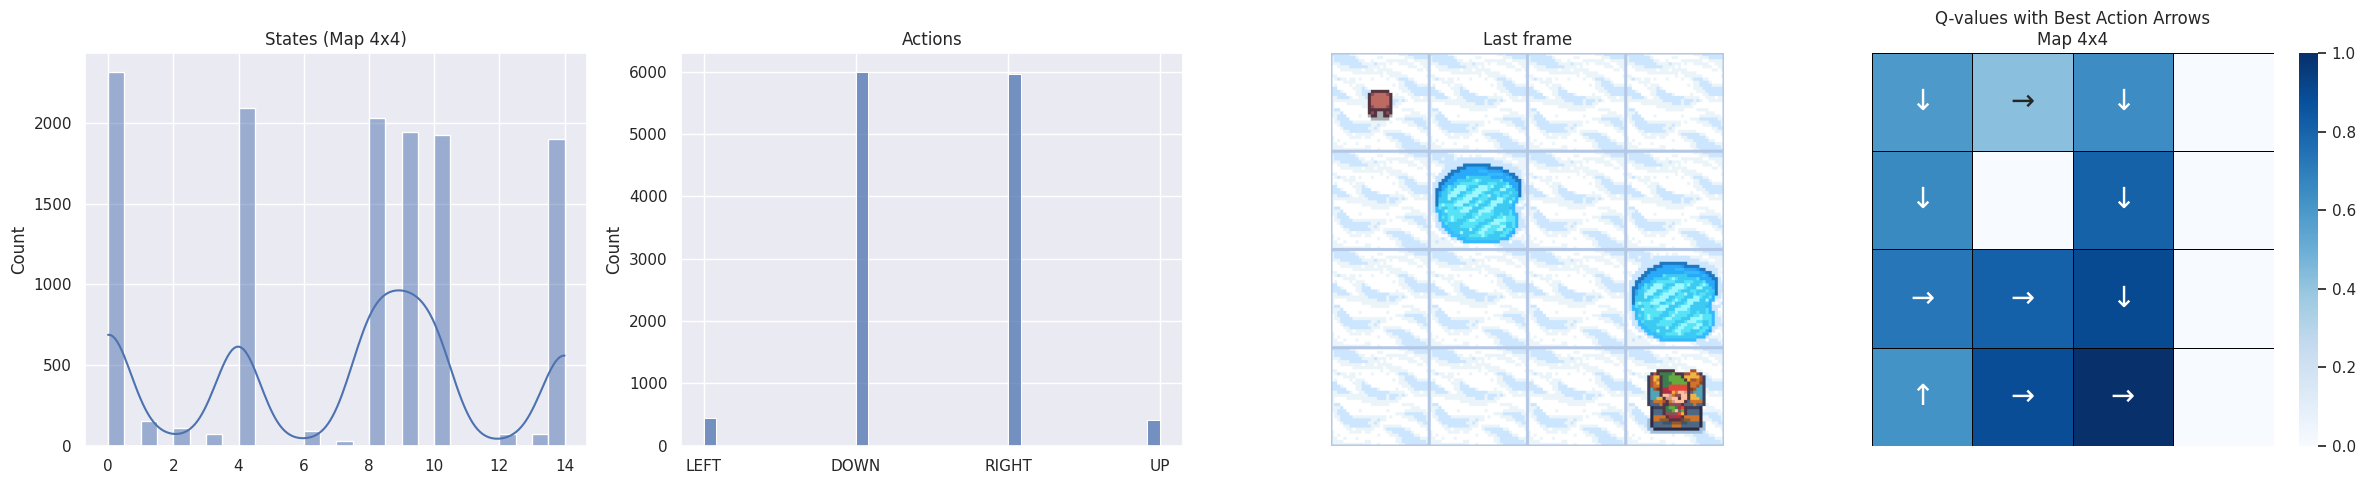


Visualizing 7x7 with hyper-parameters => α=0.5, γ=0.9, ε=0.05



Q-learning avg reward (last 100): 0.950
Policy Iteration avg reward:      1.000


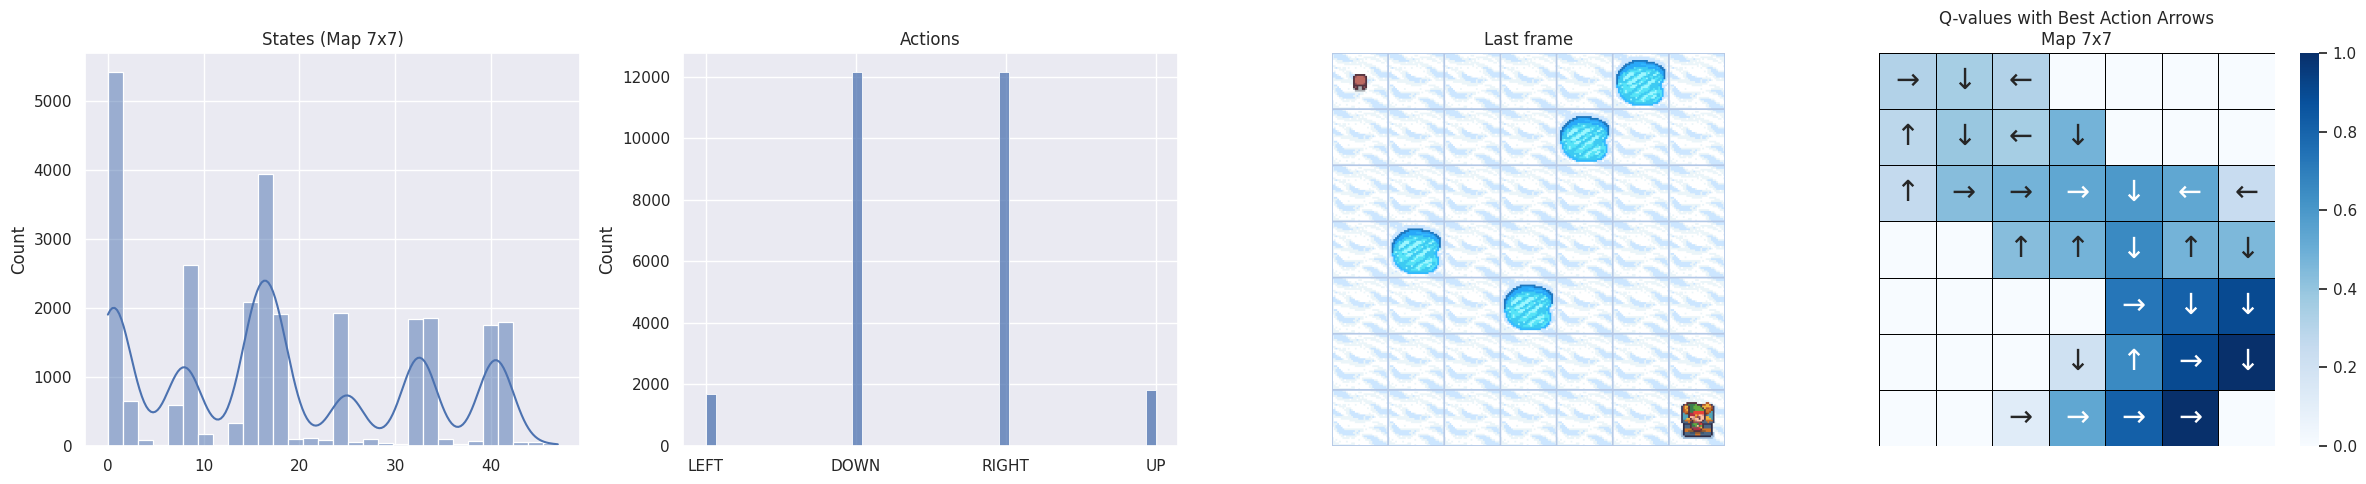


Visualizing 9x9 with hyper-parameters => α=0.1, γ=0.5, ε=0.05



Q-learning avg reward (last 100): 1.000
Policy Iteration avg reward:      1.000


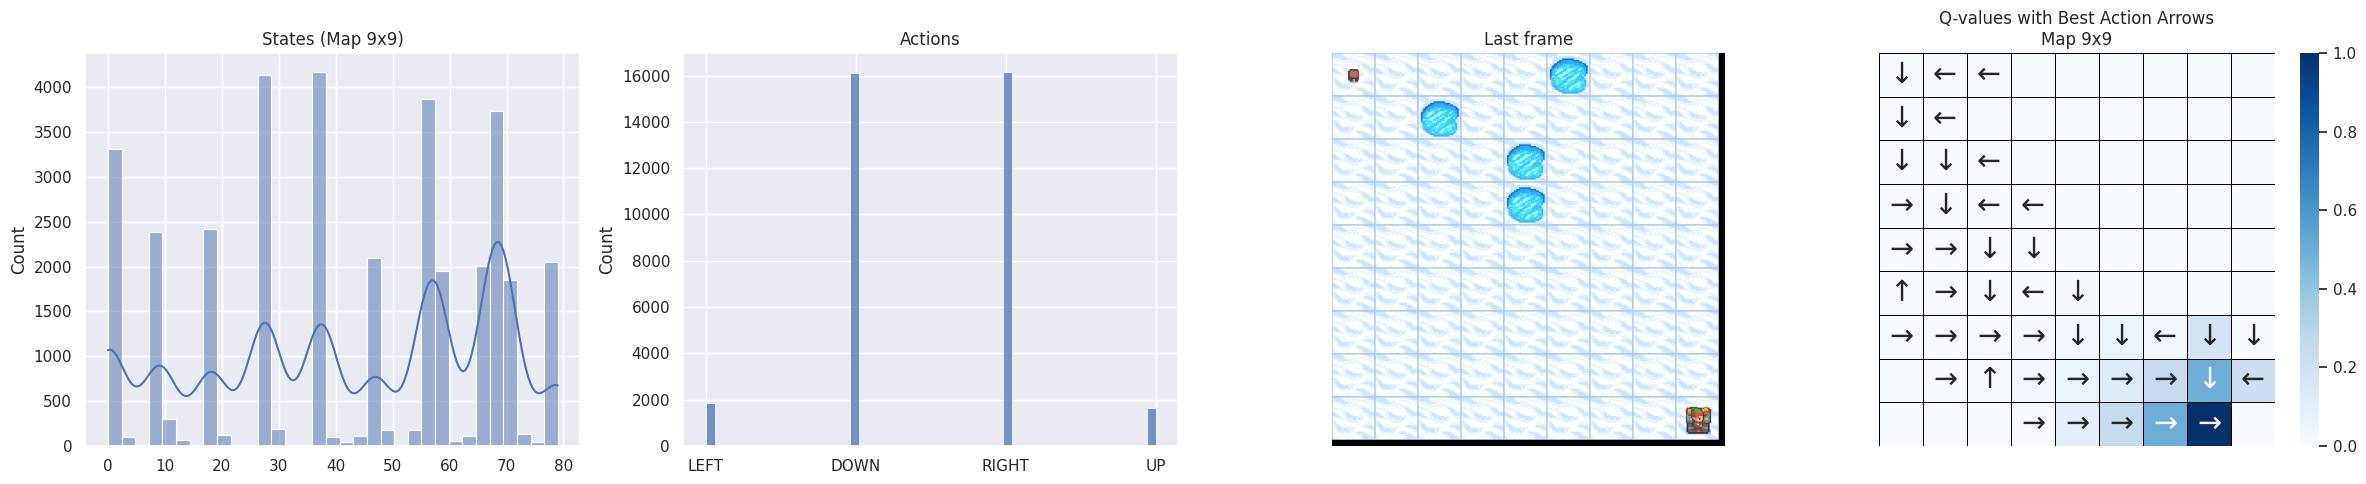

In [ ]:
best_hyperparams = []

for size in df_results["Map Size"].unique():
    best_row = (
        df_results[df_results["Map Size"] == size]
        .sort_values("Avg Reward (Last 100)", ascending=False)
        .iloc[0]
    )
    best_hyperparams.append({
        "map_size": int(size.split("x")[0]),
        "alpha": best_row["Alpha"],
        "gamma": best_row["Gamma"],
        "epsilon": best_row["Epsilon"]
    })

print("Best hyperparameter combinations extracted:")
for hp in best_hyperparams:
    print(hp)


results = []

# Visualize results
for combo in best_hyperparams:
    map_size = combo["map_size"]
    alpha = combo["alpha"]
    gamma = combo["gamma"]
    epsilon = combo["epsilon"]

    print("\n============================================================================================================")
    print(f"Visualizing {map_size}x{map_size} with hyper-parameters => α={alpha}, γ={gamma}, ε={epsilon}")
    print("============================================================================================================\n")

    env = gym.make(
        "FrozenLake-v1",
        is_slippery=params.is_slippery,
        render_mode="rgb_array",
        desc=generate_random_map(size=map_size, p=params.proba_frozen, seed=params.seed),
    )

    state_size = env.observation_space.n
    action_size = env.action_space.n

    agent = QLearning(alpha, gamma, state_size, action_size)
    policy = EpsilonGreedy(epsilon)

    all_states, all_actions = [], []
    rewards, steps = [], []

    for episode in tqdm(range(params.total_episodes), desc=f"{map_size}x{map_size} Training", leave=False):
        state, _ = env.reset(seed=params.seed)
        done = False
        total_reward = 0
        step_count = 0

        while not done:
            action = policy.choose_action(env.action_space, state, agent.qtable)
            all_states.append(state)
            all_actions.append(action)
            new_state, reward, terminated, truncated, _ = env.step(action)
            agent.update(state, action, reward, new_state)
            state = new_state
            total_reward += reward
            step_count += 1
            done = terminated or truncated
        rewards.append(total_reward)
        steps.append(step_count)

    # --- Compare with Policy Iteration ---
    policy_pi, V_pi = policy_iteration(env, gamma=0.99)
    avg_q_reward = np.mean(rewards[-100:])
    avg_pi_reward = evaluate_policy(env, policy_pi, episodes=100)

    print(f"Q-learning avg reward (last 100): {avg_q_reward:.3f}")
    print(f"Policy Iteration avg reward:      {avg_pi_reward:.3f}")


    results.append(pd.DataFrame({
        "Episode": range(params.total_episodes),
        "Reward": rewards,
        "Steps": steps,
        "Map Size": f"{map_size}x{map_size}"
    }))

    plot_all_visualizations(all_states, all_actions, agent.qtable, env, map_size)
    env.close()


Plot summary across map sizes - 4x4, 7x7, 9x9

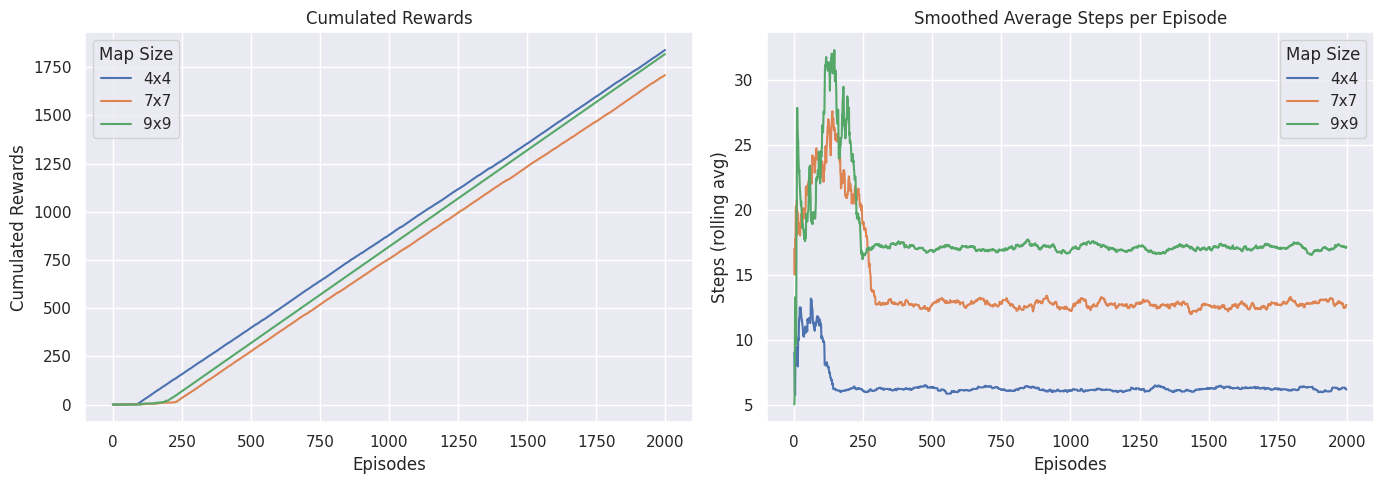

In [ ]:
df = pd.concat(results, ignore_index=True)

plt.figure(figsize=(14, 5))

# Cumulated rewards
plt.subplot(1, 2, 1)
cum_rewards = df.groupby(["Map Size", "Episode"])["Reward"].sum().groupby(level=0).cumsum().reset_index()
sns.lineplot(data=cum_rewards, x="Episode", y="Reward", hue="Map Size")
plt.title("Cumulated Rewards")
plt.ylabel("Cumulated Rewards")
plt.xlabel("Episodes")

# Smoothed step count
plt.subplot(1, 2, 2)
df['Smoothed Steps'] = df.groupby("Map Size")["Steps"].transform(lambda x: x.rolling(50, min_periods=1).mean())
sns.lineplot(data=df, x="Episode", y="Smoothed Steps", hue="Map Size")
plt.title("Smoothed Average Steps per Episode")
plt.ylabel("Steps (rolling avg)")
plt.xlabel("Episodes")

plt.tight_layout()
plt.show()

#PART 2

In [ ]:
!pip install "gym[atari,accept-rom-license]" ale-py
!pip install "gym[atari,accept-rom-license]" opencv-python moviepy

Moviepy - Building video /content/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-0.mp4
Episode 0 | Reward: 5.0 | Epsilon: 0.9950
Episode 1 | Reward: 0.0 | Epsilon: 0.9900
Episode 2 | Reward: 4.0 | Epsilon: 0.9851
Episode 3 | Reward: 0.0 | Epsilon: 0.9801
Episode 4 | Reward: 0.0 | Epsilon: 0.9752
Episode 5 | Reward: 2.0 | Epsilon: 0.9704
Episode 6 | Reward: 1.0 | Epsilon: 0.9655
Episode 7 | Reward: 3.0 | Epsilon: 0.9607
Episode 8 | Reward: 0.0 | Epsilon: 0.9559
Episode 9 | Reward: 2.0 | Epsilon: 0.9511
Episode 10 | Reward: 0.0 | Epsilon: 0.9464
Episode 11 | Reward: 1.0 | Epsilon: 0.9416
Episode 12 | Reward: 2.0 | Epsilon: 0.9369
Episode 13 | Reward: 0.0 | Epsilon: 0.9322
Episode 14 | Reward: 2.0 | Epsilon: 0.9276
Episode 15 | Reward: 0.0 | Epsilon: 0.9229
Episode 16 | Reward: 0.0 | Epsilon: 0.9183
Episode 17 | Reward: 0.0 | Epsilon: 0.9137
Episode 18 | Reward: 2.0 | Epsilon: 0.9092
Episode 19 | Reward: 4.0 | Epsilon: 0.9046
Episode 20 | Reward: 2.0 | Epsilon: 0.9001
Episode 21 | Reward: 2.0 | Ep

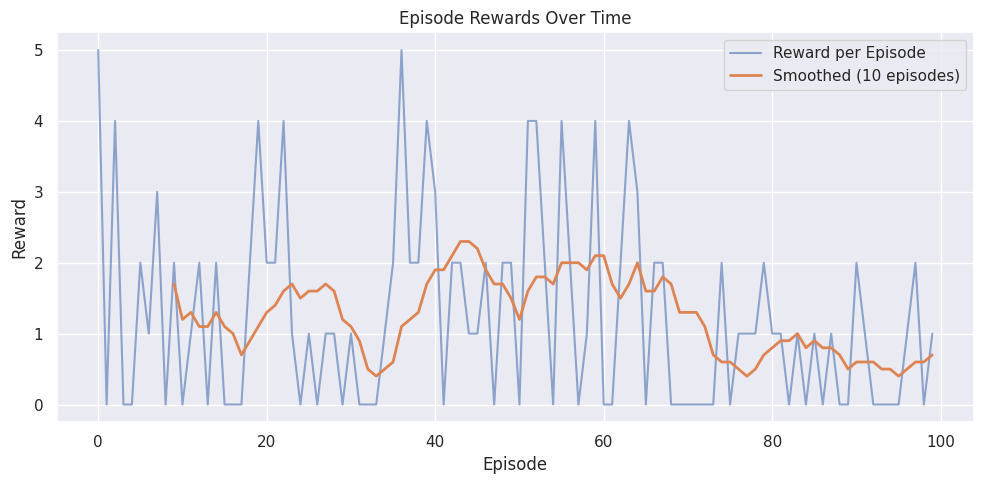

In [ ]:
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

import tensorflow as tf
from tensorflow import keras
from collections import deque
import random
import gym
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from gym.wrappers import RecordVideo
import logging
import moviepy.editor
import base64
from IPython.display import HTML

# Suppress video logging
moviepy.editor.logger = logging.getLogger("moviepy")
moviepy.editor.logger.setLevel(logging.ERROR)

# Environment setup
env = gym.make("BreakoutNoFrameskip-v4", render_mode="rgb_array")
env = gym.wrappers.AtariPreprocessing(env, grayscale_obs=True)
env = gym.wrappers.FrameStack(env, 4)
env = RecordVideo(env, video_folder="./videos", episode_trigger=lambda ep: ep == 0)

input_shape = (84, 84, 4)
action_space = env.action_space.n

# Hyperparameters
learning_rate = 0.00025
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.995
batch_size = 32
train_start = 10000
update_target_steps = 1000
memory = deque(maxlen=100000)

# Q-network
def create_q_model(input_shape, action_space):
    inputs = keras.Input(shape=input_shape)
    x = keras.layers.Conv2D(32, 8, strides=4, activation='relu')(inputs)
    x = keras.layers.Conv2D(64, 4, strides=2, activation='relu')(x)
    x = keras.layers.Conv2D(64, 3, strides=1, activation='relu')(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    outputs = keras.layers.Dense(action_space, activation='linear')(x)
    return keras.Model(inputs, outputs)

model = create_q_model(input_shape, action_space)
target_model = create_q_model(input_shape, action_space)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='huber')
target_model.set_weights(model.get_weights())

# Training loop
num_episodes = 100
total_steps = 0
reward_history = []

for episode in range(num_episodes):
    state, _ = env.reset()
    state = np.transpose(state, (1, 2, 0))  # (4, 84, 84) → (84, 84, 4)
    done = False
    total_reward = 0
    step_count = 0

    while not done:
        # ε-greedy
        if np.random.rand() <= epsilon:
            action = env.action_space.sample()
        else:
            q_values = model.predict(np.expand_dims(state, axis=0), verbose=0)
            action = np.argmax(q_values[0])

        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = np.transpose(next_state, (1, 2, 0))
        done = terminated or truncated

        memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        step_count += 1
        total_steps += 1

        # Train
        if len(memory) >= train_start:
            minibatch = random.sample(memory, batch_size)
            states = np.array([m[0] for m in minibatch])
            actions = np.array([m[1] for m in minibatch])
            rewards = np.array([m[2] for m in minibatch])
            next_states = np.array([m[3] for m in minibatch])
            dones = np.array([m[4] for m in minibatch])

            target_q = model.predict(states, verbose=0)
            next_q = target_model.predict(next_states, verbose=0)

            for i in range(batch_size):
                if dones[i]:
                    target_q[i][actions[i]] = rewards[i]
                else:
                    target_q[i][actions[i]] = rewards[i] + gamma * np.max(next_q[i])

            model.fit(states, target_q, batch_size=batch_size, verbose=0)

        # Update target network
        if total_steps % update_target_steps == 0:
            target_model.set_weights(model.get_weights())

        if step_count > 10000:
            print("Episode stopped (too long)")
            break

    # Log
    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    reward_history.append(total_reward)
    print(f"Episode {episode} | Reward: {total_reward} | Epsilon: {epsilon:.4f}")

env.close()

# Reward Visualization
plt.figure(figsize=(10, 5))
plt.plot(reward_history, label="Reward per Episode", alpha=0.6)
plt.plot(pd.Series(reward_history).rolling(10).mean(), label="Smoothed (10 episodes)", linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Episode Rewards Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


###Game Visualization

In [ ]:
import base64
from IPython.display import HTML

def show_video(path):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + base64.b64encode(mp4).decode()
    return HTML(f"<video width=400 controls><source src='{data_url}' type='video/mp4'></video>")

show_video("./videos/rl-video-episode-0.mp4")


###Summary
| **Part 1 (FrozenLake)**    | **Part 2 (BreakoutNoFrameskip-v4)**           |
| -------------------------- | --------------------------------------------- |
| Uses a Q-table             | Uses a neural network to approximate Q-values |
| Discrete small state space | High-dimensional visual input (84×84×4)       |
| Chooses action from table  | Chooses action from predicted Q-values        |
| Basic loop over episodes   | Same loop + replay buffer + target net        |
